Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn import datasets
X, y = datasets.load_digits(n_class=10, return_X_y=True)

In [2]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

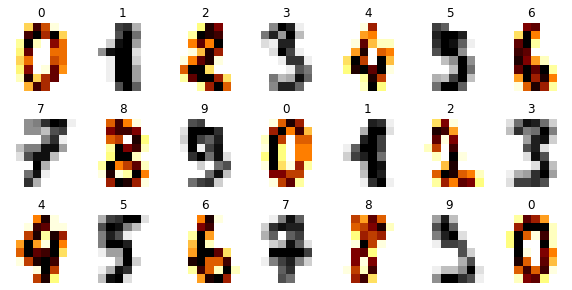

In [4]:
_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.obj_func = None
        self.cluster_centers_ = None
        self.labels_ = None
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        return euclidean_distances(X,cluster_centers)
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        
        k_pred = []
        dist = self.calculate_distances_to_centroids(X, nearest_clusters)
        for i in range(X.shape[0]):
            k_pred.append(np.argmin(dist[i]))
        k_pred = np.array(k_pred)
        
        centroid_upd = np.zeros(X.shape[1]*nearest_clusters.shape[0]).reshape(nearest_clusters.shape[0],X.shape[1])
        for j in range(nearest_clusters.shape[0]):
            X_clusters = X[k_pred==j].copy()
            centroid_upd[j] = np.mean(X_clusters,axis=0)
        return centroid_upd
    
    def nearest_clusters(self,X,centroid):
        ''' Returns numpy array (n,), where n = X.shape[0],
        which consist of cluster number for every object in X data
        '''
        k_pred = []
        dist = self.calculate_distances_to_centroids(X, centroid)
        for i in range(X.shape[0]):
            k_pred.append(np.argmin(dist[i]))
        return np.array(k_pred)
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        
        for i in range(self.n_init):
            random_index = np.random.choice(X.shape[0],self.n_clusters)
            self.cluster_centers_ = X[random_index].copy()
            for j in range(self.max_iter):
                X_clusters = self.nearest_clusters(X,self.cluster_centers_)
                obj_func_value = 0
                for k in np.unique(X_clusters):
                    X_dist = self.calculate_distances_to_centroids(X[X_clusters==k], self.cluster_centers_)
                    dist_clust = X_dist[:,k] #X.shape-dimension np.array
                    obj_func_value += np.linalg.norm(dist_clust)**2
                if self.obj_func is None or self.obj_func > obj_func_value:
                    self.obj_func = int(obj_func_value)
                    self.cluster_centers_ = self.update_centroids(X,self.cluster_centers_)   
        return self
            
    

    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            self.labels_ = self.nearest_clusters(X,self.cluster_centers_)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
clst = CustomKMeans(n_clusters=10).fit(X)
clst.predict(X)

Проверка на то, что находит точки классов и считает их

In [8]:
np.unique(clst.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [9]:
clst.cluster_centers_

array([[ 0.,  0.,  9., 16., 16.,  7.,  0.,  0.,  0., 13., 15.,  9., 12.,
        15.,  0.,  0.,  0.,  5.,  4.,  0., 13., 13.,  0.,  0.,  0.,  0.,
         0., 11., 16.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  3.,
         0.,  0.,  0.,  0.,  0.,  4., 12., 13.,  0.,  0.,  0.,  7.,  1.,
         1., 12., 14.,  0.,  0.,  0.,  9., 16., 16., 14.,  5.,  0.],
       [ 0.,  1., 15., 16.,  4.,  0.,  0.,  0.,  0.,  9., 16., 11., 14.,
         0.,  0.,  0.,  0., 12., 10.,  5., 16.,  0.,  0.,  0.,  0.,  4.,
         7.,  8., 13.,  0.,  0.,  0.,  0.,  0.,  1., 15.,  6.,  0.,  0.,
         0.,  0.,  0.,  5., 16.,  2.,  0.,  0.,  0.,  0.,  4., 15., 14.,
        10., 11., 12.,  1.,  0.,  0., 13., 16., 16., 15., 11.,  1.],
       [ 0.,  0.,  4., 14.,  9.,  0.,  0.,  0.,  0.,  0., 13., 16., 16.,
        10.,  0.,  0.,  0.,  4., 16.,  4.,  5., 16.,  6.,  0.,  0.,  8.,
        14.,  0.,  1., 15.,  5.,  0.,  0.,  6., 16.,  0.,  0., 13.,  4.,
         0.,  0.,  4., 15.,  1.,  7., 16.,  1.,  0.,  0.,  

In [10]:
custom_kmeans_labels = clst.labels_
assert custom_kmeans_labels.shape == (1797,)

Визуализируем центры классов кастомноого класса

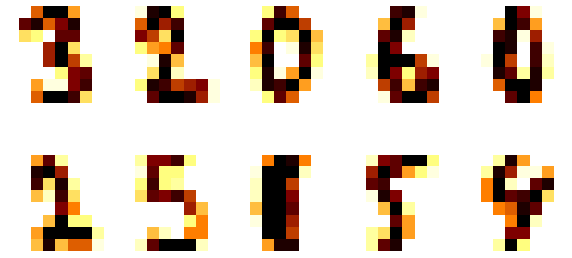

In [11]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), clst.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.afmhot_r)

Для сравнения загрузим библиотечный модуль и прогоним по тем же параметрам и его

In [12]:
from sklearn.cluster import AgglomerativeClustering,KMeans
k_means = KMeans(n_clusters=10,max_iter=30, n_init=10, init='random').fit(X)

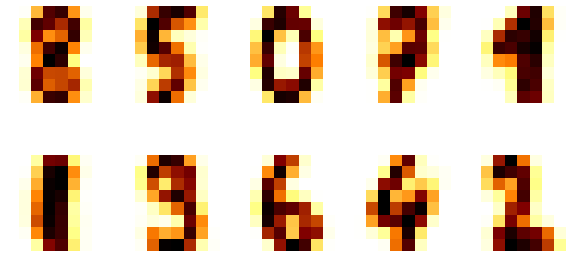

In [13]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), k_means.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.afmhot_r)

KMeans так же с такими же параметрами не совсем точно отображает центры кластеров

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

Проверим изменение функции расстояния от количества рандомных инициализаций и количества циклов повторения расчетов центроидов

In [14]:
max_iters,inits = [1,10,30,50,100],[1,5,10,15,20]
for j in inits:
#for j in max_iters: #cols
    clst = CustomKMeans(n_clusters=10,n_init=j).fit(X)
    print(f'n_init - {j}, obj_func - {clst.obj_func}')

n_init - 1, obj_func - 1206255
n_init - 5, obj_func - 1169544
n_init - 10, obj_func - 1238724
n_init - 15, obj_func - 1169655
n_init - 20, obj_func - 1175174


In [15]:
for j in max_iters:
    clst = CustomKMeans(n_clusters=10,max_iter=j).fit(X)
    print(f'n_iters - {j}, obj_func - {clst.obj_func}')

n_iters - 1, obj_func - 2175041
n_iters - 10, obj_func - 1218137
n_iters - 30, obj_func - 1192440
n_iters - 50, obj_func - 1241023
n_iters - 100, obj_func - 1169582


Сравним с библиотечной (правда она быстрее, взял большие значения инитов и итеров)

In [16]:
max_iters,inits = [1,100,300,500,1000],[1,5,10,50,200]
for j in inits:
#for j in max_iters: #cols
    clst = KMeans(n_clusters=10,n_init=j,init='random').fit(X)
    print(f'n_init - {j}, obj_func - {clst.inertia_}')

n_init - 1, obj_func - 1210092.73800623
n_init - 5, obj_func - 1165167.1632522924
n_init - 10, obj_func - 1165340.6026759818
n_init - 50, obj_func - 1165158.2485126616
n_init - 200, obj_func - 1165125.4432892378


In [17]:
for j in max_iters: #cols
    clst = KMeans(n_clusters=10,max_iter=j,init='random').fit(X)
    print(f'n_iters - {j}, obj_func - {clst.inertia_}')

n_iters - 1, obj_func - 1288321.0173555291
n_iters - 100, obj_func - 1165222.011705854
n_iters - 300, obj_func - 1165178.2967973
n_iters - 500, obj_func - 1168384.2425441982
n_iters - 1000, obj_func - 1170023.1214747033


В целом, значение функции для кастомного класса минимально для 1 и 10 инициализации, а итерации - это 30 и 100. В библиотечном классе значение функции практически не меняется после 1 инициализации и 1 итерации (макс значение функции как раз в 1 инит, 1 итер)

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [18]:
hierarchical = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical.labels_
kmeans = KMeans(n_clusters=10).fit(X)
kmeans_labels = kmeans.labels_

In [19]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

KMeans

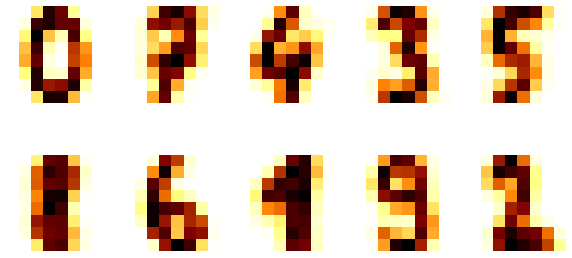

In [20]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), kmeans.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.afmhot_r)

Hierarchical

In [21]:
hierarchical_centroids = np.zeros(640).reshape(10,64)

In [22]:
for i in range(10):
    x_clust = X[hierarchical_labels==i]
    mean = np.mean(x_clust,axis=0,dtype='int32')
    hierarchical_centroids[i] = mean

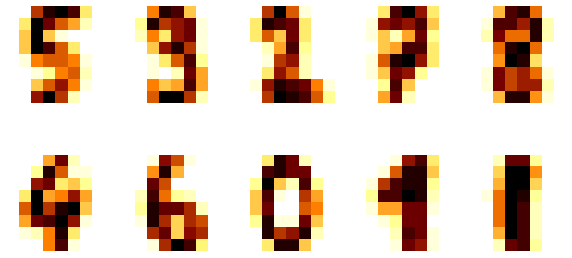

In [23]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image in zip(axes.flatten(), hierarchical_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.afmhot_r)

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [24]:
from sklearn.metrics import silhouette_score,silhouette_samples

kmeans_silhouette = []
for i in range(2,21):
    clst = KMeans(n_clusters=i).fit(X)
    kmeans_silhouette.append(silhouette_score(X,clst.labels_))

In [25]:
hierarchical_silhouette = []
for i in range(2,21):
    clst = AgglomerativeClustering(n_clusters=i).fit(X)
    hierarchical_silhouette.append(silhouette_score(X,clst.labels_))

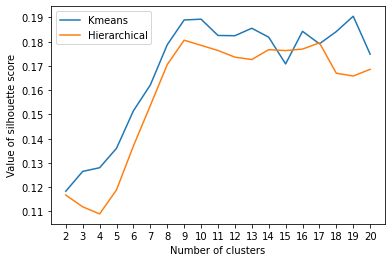

In [26]:
sns.lineplot(x=range(2,21),y=kmeans_silhouette).set(ylabel='Value of silhouette score')
sns.lineplot(x=range(2,21),y=hierarchical_silhouette).set(xticks = np.linspace(2,20,19),xlabel='Number of clusters');
plt.legend(labels=['Kmeans','Hierarchical']);

На графиках видно несколько пиков, соответствующих количеству классов с лучшим разделением, но только в 10 кластерах эти пики совпадают

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [27]:
from sklearn.metrics import homogeneity_score,completeness_score,v_measure_score

In [28]:
homogenity_kmeans, completeness_kmeans, v_score_kmeans = [],[],[]
for i in range(2,21):
    clst = KMeans(n_clusters=i).fit(X)
    homogenity_kmeans.append(homogeneity_score(y,clst.labels_))
    completeness_kmeans.append(completeness_score(y,clst.labels_))
    v_score_kmeans.append(v_measure_score(y,clst.labels_))

In [29]:
homogenity_hierarchical, completeness_hierarchical, v_score_hierarchical = [],[],[]
for i in range(2,21):
    clst = AgglomerativeClustering(n_clusters=i).fit(X)
    homogenity_hierarchical.append(homogeneity_score(y,clst.labels_))
    completeness_hierarchical.append(completeness_score(y,clst.labels_))
    v_score_hierarchical.append(v_measure_score(y,clst.labels_))

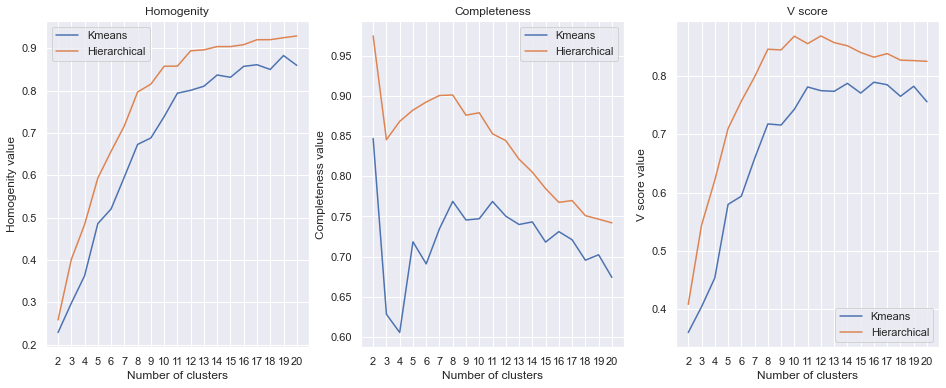

In [30]:
sns.set(rc={'figure.figsize':(16,6)})
plt.subplot(1,3,1)
sns.lineplot(x=range(2,21),y=homogenity_kmeans).set(title='Homogenity',ylabel='Homogenity value')
sns.lineplot(x=range(2,21),y=homogenity_hierarchical).set(xticks = np.linspace(2,20,19),xlabel='Number of clusters')
plt.legend(labels=['Kmeans','Hierarchical']);
plt.subplot(1,3,2)
sns.lineplot(x=range(2,21),y=completeness_kmeans).set(title='Completeness',ylabel='Completeness value')
sns.lineplot(x=range(2,21),y=completeness_hierarchical).set(xticks = np.linspace(2,20,19),xlabel='Number of clusters')
plt.legend(labels=['Kmeans','Hierarchical']);
plt.subplot(1,3,3)
sns.lineplot(x=range(2,21),y=v_score_kmeans).set(title='V score',ylabel='V score value')
sns.lineplot(x=range(2,21),y=v_score_hierarchical).set(xticks = np.linspace(2,20,19),xlabel='Number of clusters');

plt.legend(labels=['Kmeans','Hierarchical']);

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [31]:
from sklearn.decomposition import TruncatedSVD

In [32]:
for x in [2,5,10,20]:
    X_trans = TruncatedSVD(n_components=x).fit_transform(X)
    hierarchical = AgglomerativeClustering(n_clusters=10).fit(X_trans)
    hierarchical_labels = hierarchical.labels_
    kmeans = KMeans(n_clusters=10).fit(X_trans)
    kmeans_labels = kmeans.labels_
    print(f'For heirarchical algorithm with {x} components:')
    print(f'silhouette score - {silhouette_score(X,hierarchical_labels)}')
    print(f'V score - {v_measure_score(y,hierarchical_labels)}\n')
    print(f'For KMeans algorithm with {x} components:')
    print(f'silhouette score - {silhouette_score(X,kmeans_labels)}')
    print(f'V score - {v_measure_score(y,kmeans_labels)}\n')

For heirarchical algorithm with 2 components:
silhouette score - -0.007681018630218928
V score - 0.3337189903948925

For KMeans algorithm with 2 components:
silhouette score - 0.0061769801972886736
V score - 0.34688889910342496

For heirarchical algorithm with 5 components:
silhouette score - 0.1620113963829507
V score - 0.6756036446423491

For KMeans algorithm with 5 components:
silhouette score - 0.16846545768363508
V score - 0.6349670267154036

For heirarchical algorithm with 10 components:
silhouette score - 0.1765881132796084
V score - 0.8259753348813222

For KMeans algorithm with 10 components:
silhouette score - 0.1805003746296982
V score - 0.7174964181987789

For heirarchical algorithm with 20 components:
silhouette score - 0.17048272637592188
V score - 0.7956568736920284

For KMeans algorithm with 20 components:
silhouette score - 0.18229407154541885
V score - 0.7450541962027137



Как мы можем увидеть, наилучший скор обоих метрик получился у Иерархического алгоритма с 10 главными компонентами, а  у KMeans с 20 главными компонентами

In [33]:
X_trans = TruncatedSVD(n_components=10).fit_transform(X)
hierarchical = AgglomerativeClustering(n_clusters=10).fit(X_trans)
hierarchical_labels = hierarchical.labels_
original_hie = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels_original = original_hie.labels_
print(f'For heirarchical algorithm with 10 components:')
print(f'silhouette score - {silhouette_score(X,hierarchical_labels)}')
print(f'V score - {v_measure_score(y,hierarchical_labels)}\n')
print(f'For heirarchical algorithm with original data:')
print(f'silhouette score - {silhouette_score(X,hierarchical_labels_original)}')
print(f'V score - {v_measure_score(y,hierarchical_labels_original)}\n')

For heirarchical algorithm with 10 components:
silhouette score - 0.1765881132796084
V score - 0.8259753348813222

For heirarchical algorithm with original data:
silhouette score - 0.17849659940596496
V score - 0.8681701126909083



In [34]:
X_trans = TruncatedSVD(n_components=20).fit_transform(X)
kmeans = KMeans(n_clusters=10).fit(X_trans)
kmeans_labels = kmeans.labels_
kmeans_original = KMeans(n_clusters=10).fit(X)
kmeans_labels_original = kmeans_original.labels_

print(f'For KMeans algorithm with 20 components:')
print(f'silhouette score - {silhouette_score(X,kmeans_labels)}')
print(f'V score - {v_measure_score(y,kmeans_labels)}\n')
print(f'For KMeans algorithm with original data:')
print(f'silhouette score - {silhouette_score(X,kmeans_labels_original)}')
print(f'V score - {v_measure_score(y,kmeans_labels_original)}\n')

For KMeans algorithm with 20 components:
silhouette score - 0.18237119743596733
V score - 0.741105242858986

For KMeans algorithm with original data:
silhouette score - 0.1823031463498527
V score - 0.7417990799315546



Для heirarchical algorithm с оригинальными данными значения получились получше, так же как и для KMeans, но у KMeans эти значения близки, а для heirarchical различия видны

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [35]:
from sklearn.manifold import TSNE

In [36]:
tsne = TSNE(n_components=2).fit_transform(X)


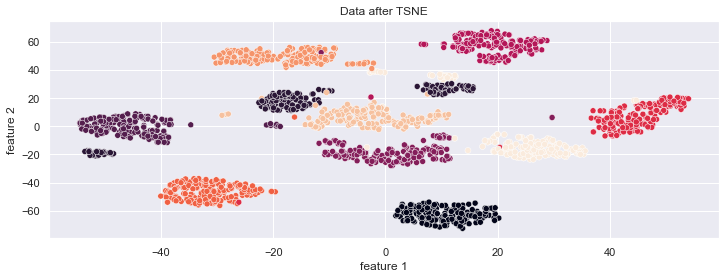

In [37]:
sns.set(rc={'figure.figsize':(12,4)})
sns.scatterplot(x=tsne.T[0],y=tsne.T[1],c=y).set(title='Data after TSNE',xlabel='feature 1',ylabel='feature 2');

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [38]:
kmeans = KMeans(n_clusters=10).fit(tsne)
kmeans_labels = kmeans.labels_
hierarchical = AgglomerativeClustering(n_clusters=10).fit(tsne)
hierarchical_labels = hierarchical.labels_

In [39]:
print(f'For heirarchical algorithm with tSNE transformed data:')
print(f'silhouette score - {silhouette_score(X,hierarchical_labels)}')
print(f'V score - {v_measure_score(y,hierarchical_labels)}\n')
print(f'For heirarchical algorithm with original data:')
print(f'silhouette score - {silhouette_score(X,hierarchical_labels_original)}')
print(f'V score - {v_measure_score(y,hierarchical_labels_original)}\n')

For heirarchical algorithm with tSNE transformed data:
silhouette score - 0.17121194216833852
V score - 0.8916446232081745

For heirarchical algorithm with original data:
silhouette score - 0.17849659940596496
V score - 0.8681701126909083



In [40]:
print(f'For KMeans algorithm with tSNE transformed data:')
print(f'silhouette score - {silhouette_score(X,kmeans_labels)}')
print(f'V score - {v_measure_score(y,kmeans_labels)}\n')
print(f'For KMeans algorithm with original data:')
print(f'silhouette score - {silhouette_score(X,kmeans_labels_original)}')
print(f'V score - {v_measure_score(y,kmeans_labels_original)}\n')

For KMeans algorithm with tSNE transformed data:
silhouette score - 0.1704616418097383
V score - 0.8919671286016921

For KMeans algorithm with original data:
silhouette score - 0.1823031463498527
V score - 0.7417990799315546



А уже тут мы видим значительный прирост V score  для обоих алгоритмов, что безусловно отлично, но силуэт у оригинальных данных лучше по прежнему (это не удивительно, все таки данные трансформированные)

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

Лучшим по V score является tSNE heirarchical, но у KMeans лучше silhouette у данных с 20 главными компонентами

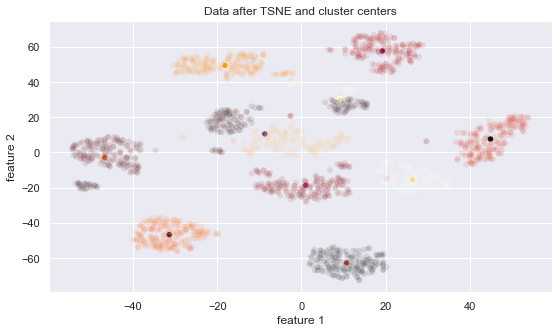

In [42]:
sns.set(rc={'figure.figsize':(9,5)})
kmeans = KMeans(n_clusters=10).fit(tsne)
sns.scatterplot(x=kmeans.cluster_centers_[:,0],
                y=kmeans.cluster_centers_[:,1],
                c=np.unique(y),cmap='inferno')
sns.scatterplot(x=tsne.T[0],y=tsne.T[1],c=y,alpha=0.1,cmap='gist_heat').set(title='Data after TSNE and cluster centers',
                                                                            xlabel='feature 1',ylabel='feature 2');

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Оба алгоритма дают похожие результаты, хотя hierarchical clustering  показывает лучший скор на некоторых характеристиках. В целом, все зависит как от настроек самих алгоритмов, так и от величины, применяемой в качестве оценочной. Настройки можно подобрать под лучший скор, а вот метрика будет зависеть уже только от того, что нужно нам в конкретном случае от кластеризации.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

Можно сохранить центры кластеров в отдельную переменную или класс, а затем применить расчеты к новым данным и выдать результатом кластер, ближайший к этому значению. Оценкой вполне может служить silhouette score, если реальные лейблы неизвестны, но если у нас есть возможность визуально сравнить точки и отнесенные к ним кластеры, то можно использовать и V score.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Улучшает, по крайней мере не искажает в той мере, чтобы кластеры совсем не получились + после понижения размерности можно визуализировать данные, чтобы убедиться в правильности или, по крайней мере, схожести отдельных групп точек

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1.) Data reconstruclion - (пока нашел такое для pca, но мб есть такое и у остальных) - разница между оригинальными значениями и восставновленными (стараться минимизировать ошибку или установить порог в относительной величине от оригинального значения)
2.) В совокупности с первым методом, прирост оценочных метрик должен быть выше % потерянной информации.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.